<a href="https://colab.research.google.com/github/rahiakela/mathematics-for-machine-learning/blob/main/deep-learning-book-maths/2_9_moore_penrose_pseudoinverse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##The Moore-Penrose Pseudoinverse

We saw that not all matrices have an inverse. It is unfortunate because the inverse is used to solve system of equations. In some cases, a system of equation has no solution, and thus the inverse doesn't exist. However it can be useful to find a value that is almost a solution (in term of minimizing the error). We will see for instance how we can find the best-fit line of a set of data points with the pseudoinverse.



##Setup

In [1]:
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Plot parameters
sns.set()
%pylab inline
pylab.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['xtick.major.size'] = 0
plt.rcParams['ytick.major.size'] = 0
# Avoid inaccurate floating values (for inverse matrices in dot product for instance)
# See https://stackoverflow.com/questions/24537791/numpy-matrix-inversion-rounding-errors
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [ ]:
def plot_vectors(vecs, cols, alpha=1):
  plt.axvline(x=0, color='#A9A9A9', zorder=0)
  plt.axhline(y=0, color='#A9A9A9', zorder=0)

  for i in range(len(vecs)):
    if (isinstance(alpha, list)):
        alpha_i = alpha[i]
    else:
        alpha_i = alpha
    x = np.concatenate([[0,0],vecs[i]])
    plt.quiver([x[0]],
                [x[1]],
                [x[2]],
                [x[3]],
                angles='xy', scale_units='xy', scale=1, color=cols[i],
                alpha=alpha)

Let's create a function that takes a 2D matrix as an input and draw the unit circle transformation when we apply this matrix to it.

In [ ]:
def plot_matrix(matrix, vectorsCol=['#FF9A13', '#1190FF']):
  """
  Modify the unit circle and basis vector by applying a matrix.
  Visualize the effect of the matrix in 2D.

  Parameters
  ----------
  matrix : array-like
      2D matrix to apply to the unit circle.
  vectorsCol : HEX color code
      Color of the basis vectors

  Returns:

  fig : instance of matplotlib.figure.Figure
      The figure containing modified unit circle and basis vectors.
  """
  # Unit circle
  x = np.linspace(-1, 1, 100000)
  y = np.sqrt(1-(x**2))
  
  # Modified unit circle (separate negative and positive parts)
  x1 = matrix[0,0]*x + matrix[0,1]*y
  y1 = matrix[1,0]*x + matrix[1,1]*y
  x1_neg = matrix[0,0]*x - matrix[0,1]*y
  y1_neg = matrix[1,0]*x - matrix[1,1]*y
  
  # Vectors
  u1 = [matrix[0,0],matrix[1,0]]
  v1 = [matrix[0,1],matrix[1,1]]
  
  plot_vectors([u1, v1], cols=[vectorsCol[0], vectorsCol[1]])

  plt.plot(x1, y1, 'g', alpha=0.5)
  plt.plot(x1_neg, y1_neg, 'g', alpha=0.5)

In [ ]:
!wget https://github.com/hadrienj/deepLearningBook-Notes/raw/master/2.8%20Singular%20Value%20Decomposition/test_svd.jpg

## Intuition

The Moore-Penrose pseudoinverse is a direct application of the SVD (see [2.8](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.8-Singular-Value-Decomposition/)). But before all, we have to remind that systems of equations can be expressed under the matrix form.

As we have seen in [2.3](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.3-Identity-and-Inverse-Matrices/), the inverse of a matrix ${A}$ can be used to solve the equation ${Ax}={b}$:

$$
{A}^{-1}{Ax}={A}^{-1}{b}
$$

$$
{I}_n{x}={A}^{-1}{b}
$$

$$
{x}={A}^{-1}{b}
$$

But in the case where the set of equations have 0 or many solutions the inverse cannot be found and the equation cannot be solved. The pseudoinverse is ${A}^+$ such as:

$$
{A}{A}^+\approx{I_n}
$$

minimizing

$$||{{A}{A}^+-{I_n}}||_2$$

The following formula can be used to find the pseudoinverse:

$$
{A}^+= {VD}^+{U}^T
$$

with ${U}$, ${D}$ and ${V}$ respectively the left singular vectors, the singular values and the right singular vectors of ${A}$ (see the SVD in [2.8](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.8-Singular-Value-Decomposition/)). ${A}^+$ is the pseudoinverse of ${A}$ and ${D}^+$ the pseudoinverse of ${D}$. We saw that ${D}$ is a diagonal matrix and thus ${D}^+$ can be calculated by taking the reciprocal of the non zero values of ${D}$.

This is a bit crude but we will see some examples to clarify all of this.

### Example 1: SVD and its pseudoinverse

Let's see how to implement that. We will create a non square matrix ${A}$, calculate its singular value decomposition and its pseudoinverse.

$$
{A}=\begin{bmatrix}
    7 & 2\\\\
    3 & 4\\\\
    5 & 3
\end{bmatrix}
$$

In [3]:
A = np.array([
  [7, 2],
  [3, 4],
  [5, 3]
])

U, D, V = np.linalg.svd(A)

D_plus = np.zeros((A.shape[0], A.shape[1])).T
D_plus[:D.shape[0], :D.shape[0]] = np.linalg.inv(np.diag(D))

A_plus = V.T.dot(D_plus).dot(U.T)
A_plus

array([[ 0.16666667, -0.10606061,  0.03030303],
       [-0.16666667,  0.28787879,  0.06060606]])

We can now check with the `pinv()` function from Numpy that the pseudoinverse is correct:

In [4]:
np.linalg.pinv(A)

array([[ 0.16666667, -0.10606061,  0.03030303],
       [-0.16666667,  0.28787879,  0.06060606]])

It looks good! We can now check that it is really the near inverse of ${A}$. Since we know that

$${A}^{-1}{A}={I_n}$$

with

$${I_2}=\begin{bmatrix}
    1 & 0 \\\\
    0 & 1
\end{bmatrix}
$$

In [5]:
A_plus.dot(A)

array([[1., 0.],
       [0., 1.]])

This is not bad! This is almost the identity matrix!

A difference with the real inverse is that ${A}^+{A}\approx{I}$ but ${A}{A}^+\neq{I}$.


In [6]:
A.dot(A_plus)

array([[ 0.83333333, -0.16666667,  0.33333333],
       [-0.16666667,  0.83333333,  0.33333333],
       [ 0.33333333,  0.33333333,  0.33333333]])

Another way of computing the pseudoinverse is to use this formula:

$$
({A}^T{A})^{-1}{A}^T
$$

The result is less acurate than the SVD method and Numpy `pinv()` uses the SVD ([cf Numpy doc](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.pinv.html)). 

Here is an example from the same matrix ${A}$:

In [7]:
A_plus_1 = np.linalg.inv(A.T.dot(A)).dot(A.T)
A_plus_1

array([[ 0.16666667, -0.10606061,  0.03030303],
       [-0.16666667,  0.28787879,  0.06060606]])

In this case the result is the same as with the SVD way.

##Over-determined System

In general there is no solution to overdetermined systems (see [2.4](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.4-Linear-Dependence-and-Span/) ; [Overdetermined systems](https://en.wikipedia.org/wiki/Overdetermined_system)). In the following picture, there is no point at the intersection of the three lines corresponding to three equations:

<img src="images/overdetermined-system-equations-python.png" width="300" alt="Example of three linear equations in 2 dimensions: this is an overdetermined system" title="Overdetermined system of equations">

<em>There is more equations (3) than unknowns (2) so this is an overdetermined system of equations</em>

The pseudoinverse solve the system in the least square error perspective: it finds the solution that minimize the error. We will see this more explicitly with an example.


>**The pseudoinverse solve the system in the least square error perspective**

###Example 2: Over-determined system of equation

For this example we will consider this set of three equations with two unknowns:

$$
\begin{cases}
-2x_1 + 2 = x_2 \\\\
4x_1 + 8 = x_2 \\\\
-1x_1 + 2 = x_2
\end{cases}
\Leftrightarrow
\begin{cases}
-2x_1 - x_2 = -2 \\\\
4x_1 - x_2 = -8 \\\\
-1x_1 - x_2 = -2
\end{cases}
$$

Let's see their graphical representation:

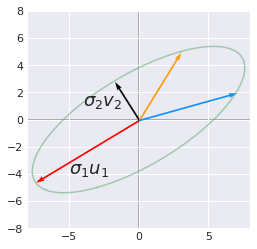

In [ ]:
u1 = [D[0] * U[0, 0], D[0] * U[0, 1]]
v1 = [D[1] * U[1, 0], D[1] * U[1, 1]]

plot_vectors([u1, v1], cols=["red", "black"])

plot_matrix(A)

plt.text(-5, -4, r"$\sigma_1u_1$", size=18)
plt.text(-4, 1, r"$\sigma_2v_2$", size=18)

plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.show()

They are the major ($\sigma_1u_1$) and minor ($\sigma_2u_2$) axes of the elipse. We can see that the feature corresponding to this major axis is associated with more variance (the range of value on this axis is bigger than the other). 

See [2.12](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.12-Example-Principal-Components-Analysis/) for more details about the variance explained.

##SVD and eigendecomposition

Now that we understand the kind of decomposition done with the SVD, we want to know how the sub-transformations are found.

The matrices ${U}$, ${D}$ and ${V}$ can be found by transforming ${A}$ in a square matrix and by computing the eigenvectors of this square matrix. The square matrix can be obtain by multiplying the matrix ${A}$ by its transpose in one way or the other:

- ${U}$ corresponds to the eigenvectors of ${AA}^\text{T}$
- ${V}$ corresponds to the eigenvectors of ${A^\text{T}A}$
- ${D}$ corresponds to the eigenvalues ${AA}^\text{T}$ or ${A^\text{T}A}$ which are the same.

Let's take an example of a non square matrix:

$$
{A}=\begin{bmatrix}
    7 & 2\\\\
    3 & 4\\\\
    5 & 3
\end{bmatrix}
$$

The singular value decomposition can be done with the `linalg.svd()` function from Numpy (note that `np.linalg.eig(A)` works only on square matrices and will give an error for `A`).

In [ ]:
A = np.array([
  [7, 2],
  [3, 4],
  [5, 3]
])

U, D, V = np.linalg.svd(A)
U

array([[-0.69366543,  0.59343205, -0.40824829],
       [-0.4427092 , -0.79833696, -0.40824829],
       [-0.56818732, -0.10245245,  0.81649658]])

In [ ]:
D

array([10.25142677,  2.62835484])

In [ ]:
V

array([[-0.88033817, -0.47434662],
       [ 0.47434662, -0.88033817]])

### Example 5: The left-singular values

The left-singular values of ${A}$ correspond to the eigenvectors of ${AA}^\text{T}$.

Note that the sign difference comes from the fact that eigenvectors are not unique. The `linalg` functions from Numpy return the normalized eigenvectors. Scaling by `-1` doesn't change their direction or the fact that they are unit vectors.

In [ ]:
U, D, V = np.linalg.svd(A)

Left singular vectors of A:

In [ ]:
U

array([[-0.69366543,  0.59343205, -0.40824829],
       [-0.4427092 , -0.79833696, -0.40824829],
       [-0.56818732, -0.10245245,  0.81649658]])

Eigenvectors of AA_transpose:

In [ ]:
np.linalg.eig(A.dot(A.T))[1]

array([[-0.69366543, -0.59343205, -0.40824829],
       [-0.4427092 ,  0.79833696, -0.40824829],
       [-0.56818732,  0.10245245,  0.81649658]])

### Example 6: The right-singular values

The right-singular values of ${A}$ correspond to the eigenvectors of ${A}^\text{T}{A}$.

In [ ]:
U, D, V = np.linalg.svd(A)

Right singular vectors of A:

In [ ]:
V

array([[-0.88033817, -0.47434662],
       [ 0.47434662, -0.88033817]])

Eigenvectors of $A^TA$:

In [ ]:
np.linalg.eig(A.T.dot(A))[1]

array([[ 0.88033817, -0.47434662],
       [ 0.47434662,  0.88033817]])

### Example 7: The nonzero singular values

The nonzero singular values of ${A}$ are the square roots of the eigenvalues of ${A}^\text{T}{A}$ and ${AA}^\text{T}$.

In [ ]:
U, D, V = np.linalg.svd(A)
D

array([10.25142677,  2.62835484])

Eigenvalues of $A^TA$:

In [ ]:
np.linalg.eig(A.T.dot(A))[0]

array([105.09175083,   6.90824917])

Eigenvalues of $AA^T$:

In [ ]:
np.linalg.eig(A.dot(A.T))[0]

array([105.09175083,   6.90824917,  -0.        ])

Square root of the eigenvalues:

In [ ]:
np.sqrt(np.linalg.eig(A.T.dot(A))[0])

array([10.25142677,  2.62835484])

## BONUS: Apply the SVD on images

In this example, we will use the SVD to extract the more important features from the image. It is nice to see the effect of the SVD on something very visual. The code is inspired/taken from [this blog post](https://www.frankcleary.com/svdimage/).

Let's start by loading an image in python and convert it to a Numpy array. We will convert it to grayscale to have one dimension per pixel. The shape of the matrix corresponds to the dimension of the image filled with intensity values: 1 cell per pixel.

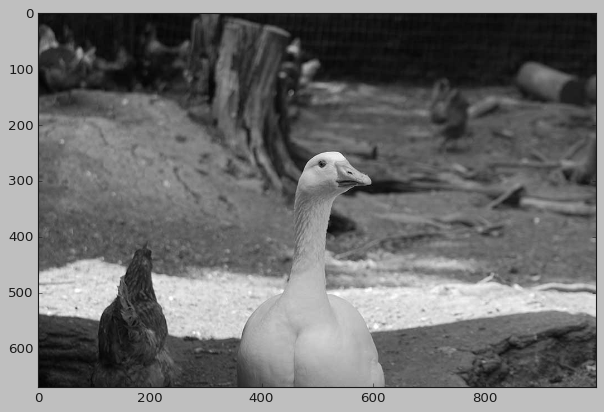

In [ ]:
plt.style.use("classic")
img = Image.open("test_svd.jpg")

# convert image to grayscale
img_gray = img.convert("LA")
# convert to numpy array
img_mat = np.array(list(img_gray.getdata(band=0)), float)
# Reshape according to orginal image dimensions
img_mat.shape = (img_gray.size[1], img_gray.size[0])

plt.figure(figsize=(9, 6))
plt.imshow(img_mat, cmap="gray")
plt.show()

We will see how to test the effect of SVD on **Lucy the goose**! 

Let's start to extract the left singular vectors, the singular values and the right singular vectors:

In [ ]:
U, D, V = np.linalg.svd(img_mat)

Let's check the shapes of our matrices:

In [ ]:
img_mat.shape

(669, 1000)

In [ ]:
U.shape

(669, 669)

In [ ]:
D.shape

(669,)

In [ ]:
V.shape

(1000, 1000)

Remember that ${D}$ are the singular values that need to be put into a diagonal matrix. Also, ${V}$ doesn't need to be transposed (see above).

The singular vectors and singular values are ordered with the first ones corresponding to the more variance explained. For this reason, using just the first few singular vectors and singular values will provide the reconstruction of the principal elements of the image.

We can reconstruct an image from a certain number of singular values. For instance for 2 singular values we will have:

<img src="https://github.com/rahiakela/mathematics-for-machine-learning/blob/main/deep-learning-book-maths/images/dimensions-reconstruction-image-singular-value-decomposition.png?raw=1" width="400" alt="The dimensions of singular value decomposition to reconstruct image from few components" title="Image reconstruction dimensions">

<em>We can reconstruct the image from few components</em>

In this example, we have reconstructed the 669px by 1000px image from two singular values. 

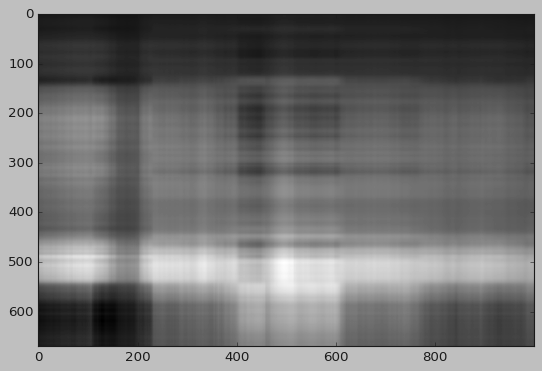

In [ ]:
img_reconst = np.matrix(U[:, :2]) * np.diag(D[:2]) * np.matrix(V[:2, :])

plt.imshow(img_reconst, cmap="gray")
plt.show()

It is hard to see Lucy with only two singular values and singular vectors. But we already see something!

We will now draw the reconstruction using different number of singular values.

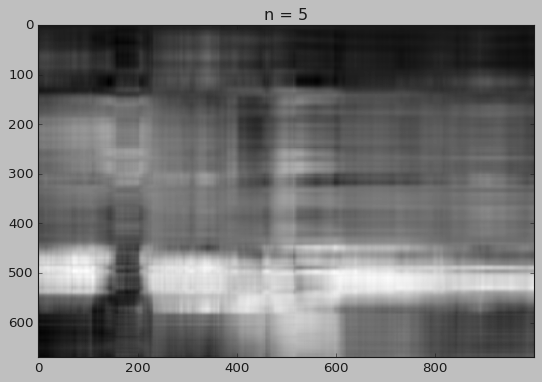

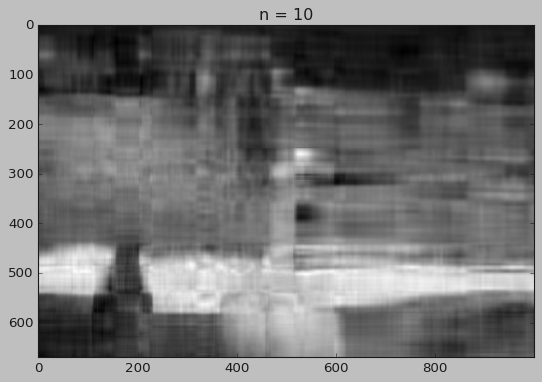

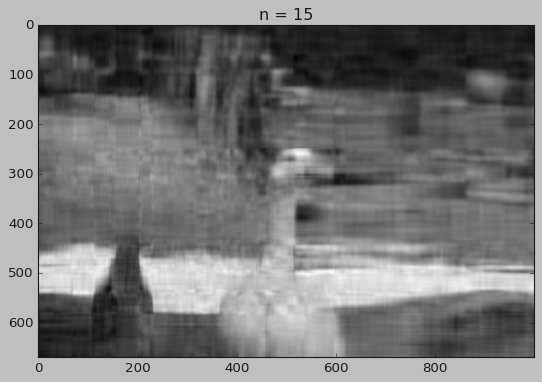

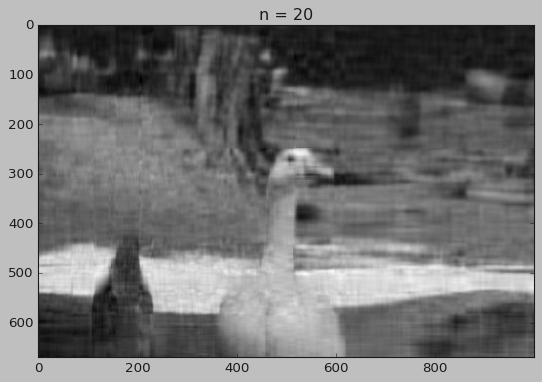

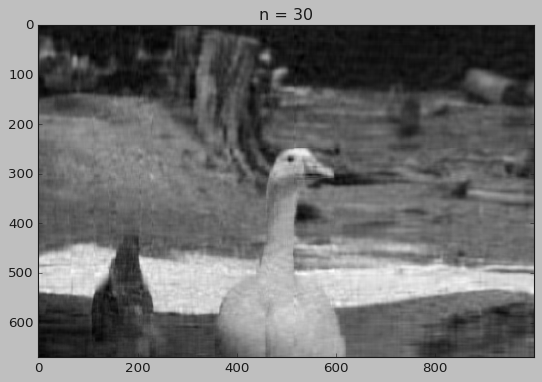

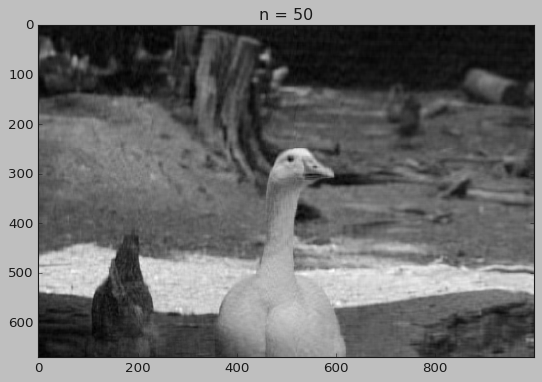

In [ ]:
for i in [5, 10, 15, 20, 30, 50]:
  img_reconst = np.matrix(U[:, :i]) * np.diag(D[:i]) * np.matrix(V[:i, :])

  plt.imshow(img_reconst, cmap="gray")
  title = f"n = {str(i)}"
  plt.title(title)
  plt.show()

Whaou! Even with 50 components, the quality of the image is not bad!

##Conclusion

I like this chapter on the SVD because it uses what we have learned so far in a concrete application. The next chapter on the pseudo-inverse is quite cool as well so keep on reading! We will see how to find a near-solution of a system of equation that minimizes the error and at the end we will see an example that uses the pseudo-inverse to find the best fit line of a set of data points.

## References

**Drawing a circle with Matplotlib**

- https://stackoverflow.com/questions/32092899/plot-equation-showing-a-circle

**Rotation matrix**

- https://en.wikipedia.org/wiki/Rotation_matrix)

**Basis vectors**

- https://en.wikipedia.org/wiki/Basis_(linear_algebra)

**Linear transformation**

- [Aran Glancy - Linear transformation and matrices](https://www.youtube.com/watch?v=kJIUbtSowRg)

**SVD**

- [Singular Value Decomposition - Wikipedia](https://en.wikipedia.org/wiki/Singular-value_decomposition)

- [Professor-svd](https://fr.mathworks.com/company/newsletters/articles/professor-svd.html)

- [Intoli - PCA and SVD](https://intoli.com/blog/pca-and-svd/)

**Numpy**

- [Numpy SVD doc](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.svd.html)

**Image processing**

- [Frank Cleary - SVD of an image](https://www.frankcleary.com/svdimage/)